In [14]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_curve, roc_auc_score
import itertools

from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

import pymorphy2
morph = pymorphy2.MorphAnalyzer()

from nltk.stem.snowball import RussianStemmer
stemmer = RussianStemmer()

%matplotlib inline

In [2]:
import pandas as pd
import re
from gensim.parsing.preprocessing import *

In [3]:
DATA_PATH = 'corpus.csv'
df = pd.read_csv(DATA_PATH,index_col=0)#, header=None, sep=';',
#                  names=['id', 'tdate', 'tmane', 'ttext', 'ttype', 'trep', 'trtw', 'tfav', 'tstcount', 
#                         'tfol', 'tfrien', 'listcount'])
print(df.shape)

(216, 4)


In [4]:
df.head()

,auto,crime,culture,education
0,"[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p style=""text-...","[<div class=""itemFullText"">\r\n<p><em><strong>..."
1,"[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p><strong><em>...","[<div class=""itemFullText"">\r\n<p><em><strong>..."
2,"[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p><em><strong>..."
3,"[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p style=""text-..."
4,"[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p><em><strong>..."


In [5]:
corpus = []
for topic in df:
    corpus += df[topic].tolist()
    
corpus = pd.Series(corpus)
corpus = corpus.apply(lambda x: x.lower())
corpus = corpus.apply(strip_tags)
corpus = corpus.apply(strip_punctuation2)
corpus = corpus.apply(strip_numeric)
corpus = corpus.apply(lambda x: re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', u' ', x))
corpus = corpus.apply(lambda x: re.sub('«|»', ' ', x))
corpus = corpus.apply(strip_multiple_whitespaces)
corpus = corpus.apply(lambda x: x.partition(' – ')[2])
# corpus = [re.sub(' +' , ' ', doc) for doc in corpus]
corpus.iloc[-1]

'сегодня в городе тольна соберутся победителей ii международного творческого детского фотоконкурса в объятиях природы организаторами масштабного проекта выступают фонд содействия развитию муниципальных образований ассоциация территорий расположения атомных электростанций ао концерн росэнергоатом и венгерская аэс пакш город полярные зори представят виктория серебренникова и екатерина таранникова в течение десяти дней в рамках работы экологического лагеря ребят ждёт увлекательная экскурсионная программа по москве с визитом в экспозиционный центр концерна росэнергоатом и будапеште в тольна российские школьники посетят серию мастер классов от известного профессионального фотохудожника балинта винце берег реки дунай маковые поля рыболовные пруды венгерские деревушки и аэс пакш список мест проведения уроков фотоискусства запланированы и съемки метеоритного дождя итогом экологического лагеря станут не только прекрасные фотографии новые знания приятные впечатления но и дружеские связи между шк

In [12]:
def str_prepr(stringa):
    res_str = stringa.lower()
    res_str = strip_tags(res_str)
    res_str = strip_punctuation2(res_str)
    res_str = strip_numeric(res_str)
    res_str = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', u' ', res_str)
    res_str = re.sub('«|»', ' ', res_str)
    res_str = res_str.partition('би порт')[2]
    res_str = re.sub('—|–', ' ', res_str)
    res_str =strip_multiple_whitespaces(res_str)
    sp = res_str.split()
    tmp_tokens = []
    for word in sp:
        if word not in stop_words.get_stop_words('ru'):
            if morph.word_is_known(word):
                tmp_tokens.append(stemmer.stem(word))
#     res_str = ' '.join(tmp_tokens)
#     res_embedding = vectorizer.transform([res_str])
#     print(res_str)
#     return res_str
    return tmp_tokens
#     res_str =res_str.partition(' – ')[2]

In [15]:
clear_df = df.apply(lambda x: x.apply(lambda y: str_prepr(y)))

---

## Prepare The Data

In [8]:
import stop_words

In [61]:
clear_df.dropna(inplace=True,axis=0)

(216, 4)

In [16]:
train_x = pd.Series()
train_y = []
test_x = pd.Series()
test_y = []
for col in clear_df.columns:
    index = [col for i in range(clear_df.crime.sample(frac=0.3).shape[0])]
    data = clear_df[col].sample(frac=0.3)
    
    train_y.extend(index)
    train_x = train_x.append(data)
    
    test_y.extend([col for i in range(clear_df[col][~clear_df[col].index.isin(data.index.values)].shape[0])])
    test_x = test_x.append(clear_df[col][~clear_df[col].index.isin(data.index.values)])

In [25]:
train_x.index = pd.RangeIndex(train_x.shape[0])
empty_mask = train_x.apply(lambda x: True if len(x)>0 else False)
train_y = pd.Series(train_y)[empty_mask].tolist()
train_x = train_x[train_x.apply(lambda x: True if len(x)>0 else False)]

In [26]:
test_x.index = pd.RangeIndex(test_x.shape[0])
empty_mask = test_x.apply(lambda x: True if len(x)>0 else False)
test_y = pd.Series(test_y)[empty_mask].tolist()
test_x = test_x[test_x.apply(lambda x: True if len(x)>0 else False)]

In [171]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(train_x.values[i], train_y[i]) for i in range(len(train_x))]
model = Doc2Vec(documents, vector_size=20, window=3, min_count=2, workers=4,dbow_words=1,hs=1)

In [172]:
vector = model.infer_vector(["мурманск", "область"])

In [173]:
vector

array([ 0.00519437,  0.0012773 , -0.00010941,  0.0019465 , -0.00372788,
       -0.01149049,  0.00980994, -0.00455104, -0.00355817, -0.00162653,
       -0.00952141,  0.02323311,  0.01105251,  0.00197638,  0.00685206,
        0.01377613, -0.02320313,  0.00813282, -0.01465167, -0.01287605],
      dtype=float32)

In [174]:
vectorized_texts = [ model.infer_vector(text) for text in test_x ]

In [175]:
from sklearn.model_selection import  train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(vectorized_texts, test_y, test_size=0.2,random_state=42, stratify=test_y)

---

## Build Models

* **Logistic Regression**
* **SVM**
* **Random Forest**
* **Gradient Boosting Trees**

**Define classifiers:**

In [176]:
y_train = np.array(Y_train)
y_test = np.array(Y_test)

In [177]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [178]:
predictor_lr = LogisticRegression().fit(X_train, y_train)

In [196]:
predictor_svm = LinearSVC(C=2.5).fit(X_train, y_train)

In [197]:
predictor_rf = RandomForestClassifier(n_estimators=1000).fit(X_train, y_train)

In [198]:
predictor_gbt = GradientBoostingClassifier(n_estimators=100).fit(X_train, y_train)

**Evaluate Classifiers:**

In [199]:
y_pred_lr = predictor_lr.predict(X_test)
print ('LR accuracy: {}'.format(round(np.mean(y_test == y_pred_lr), 2)))

LR accuracy: 0.91


In [200]:
y_pred_svm = predictor_svm.predict(X_test)
print ('svm accuracy: {}'.format(round(np.mean(y_test == y_pred_svm), 2)))

svm accuracy: 0.93


In [184]:
y_pred_rf = predictor_rf.predict(X_test)
print ('RF accuracy: {}'.format(round(np.mean(y_test == y_pred_rf), 2)))

RF accuracy: 0.9


In [185]:
y_pred_gbt = predictor_gbt.predict(X_test)
print ('GBT accuracy: {}'.format(round(np.mean(y_test == y_pred_gbt), 2)))

GBT accuracy: 0.91


### [Confusion Matrices](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py)


In [100]:
def plot_confusion_matrix(cm, title='Contingency matrix'):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[0])
    classes = [x.split('.')[-1] for x in initial_categories]
    plt.xticks(tick_marks, classes, rotation=45, size=14)
    plt.yticks(tick_marks, classes, size=14)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)

In [101]:
initial_categories = clear_df.columns.values

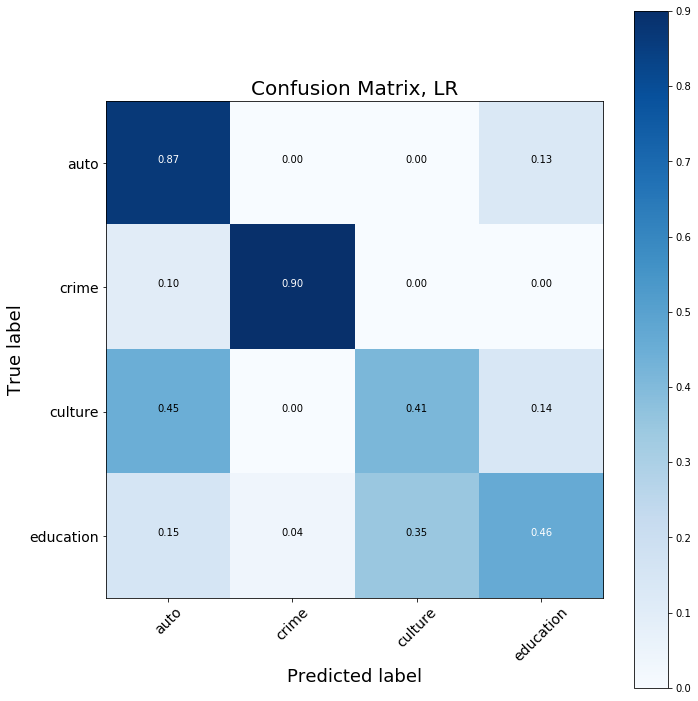

In [102]:
cmt_lr = confusion_matrix(y_test, y_pred_lr)
plot_confusion_matrix(cmt_lr, title='Confusion Matrix, LR')

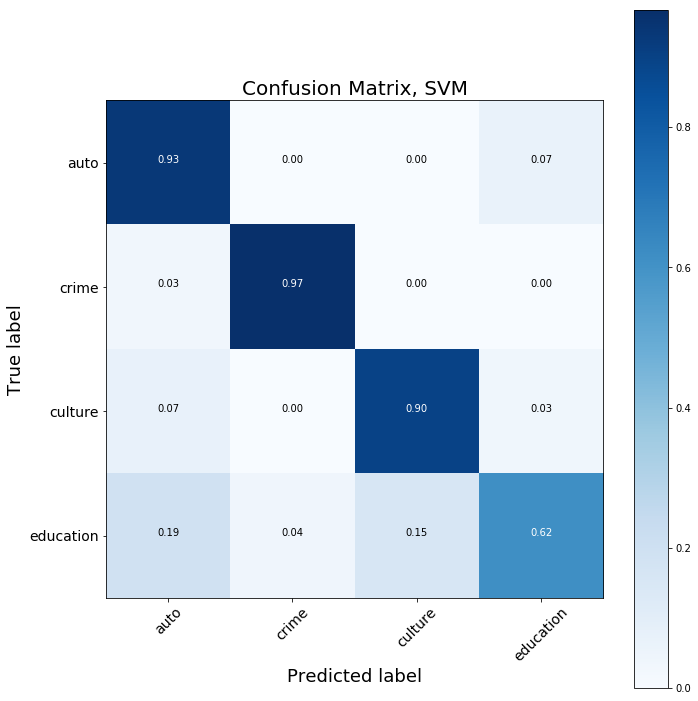

In [103]:
cmt_svm = confusion_matrix(y_test, y_pred_svm)
plot_confusion_matrix(cmt_svm, title='Confusion Matrix, SVM')

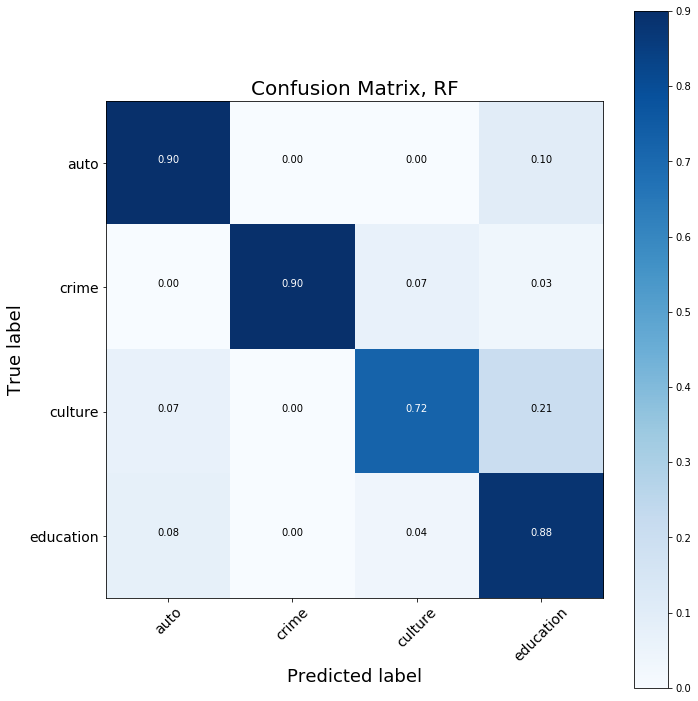

In [104]:
cmt_rf = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cmt_rf, title='Confusion Matrix, RF')

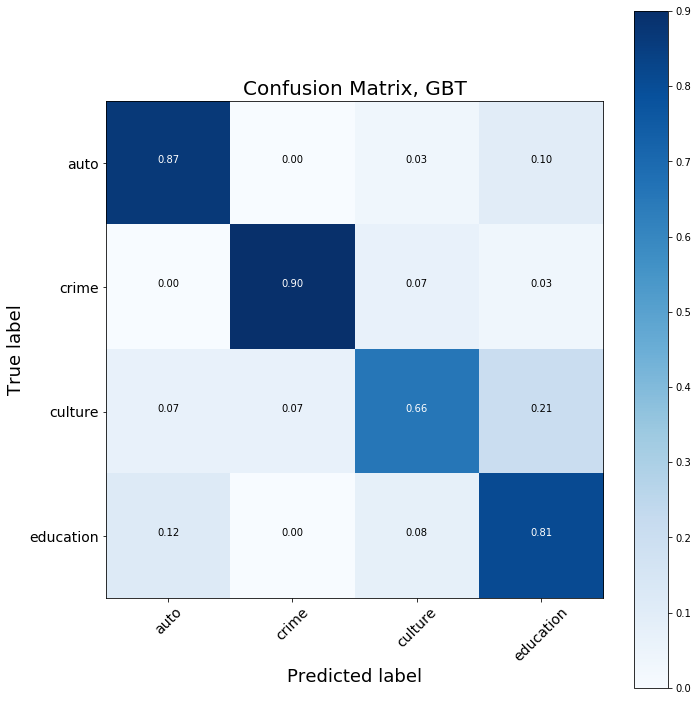

In [105]:
cmt_gbt = confusion_matrix(y_test, y_pred_gbt)
plot_confusion_matrix(cmt_gbt, title='Confusion Matrix, GBT')

### Feature Importances:

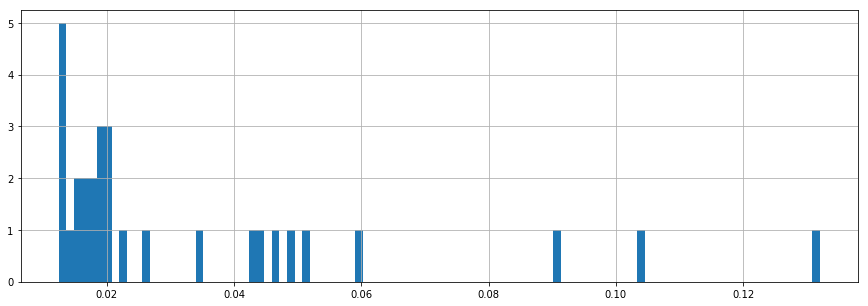

In [106]:
plt.figure(figsize=(15, 5))

plt.hist(predictor_rf.feature_importances_, bins=100)
plt.grid(True)

(0, 0.001)

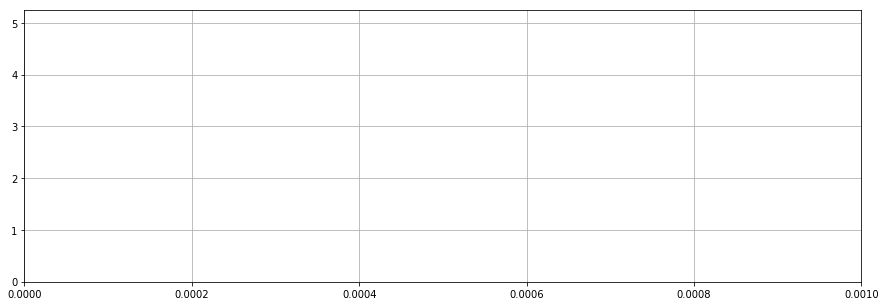

In [77]:
plt.figure(figsize=(15, 5))

plt.hist(predictor_rf.feature_importances_, bins=100)
plt.grid(True)
plt.xlim(0, 0.001)

**Create feature selector:**

In [107]:
feature_selector = SelectFromModel(RandomForestClassifier(n_estimators=10)).fit(X_train, y_train)

In [108]:
X_train_transformed = feature_selector.transform(X_train)
X_test_transformed = feature_selector.transform(X_test)

print (X_train_transformed.shape, X_test_transformed.shape)

(456, 10) (115, 10)


**Train and evaluate the new classifier:**

In [109]:
predictor_lr_ = LogisticRegression().fit(X_train_transformed, y_train)

In [110]:
y_pred_lr_ = predictor_lr_.predict(X_test_transformed)
print ('LR (with feature selection) accuracy: {}'.format(round(np.mean(y_test == y_pred_lr_), 2)))

LR (with feature selection) accuracy: 0.64


### Binary Classification

In [111]:
predictor_oneVSall = OneVsRestClassifier(LinearSVC(), n_jobs=8).fit(X_train, y_train)

In [112]:
y_pred_onevsall = predictor_oneVSall.predict(X_test)
print ('One-VS-all accuracy: {}'.format(round(np.mean(y_test == y_pred_onevsall), 2)))

One-VS-all accuracy: 0.84


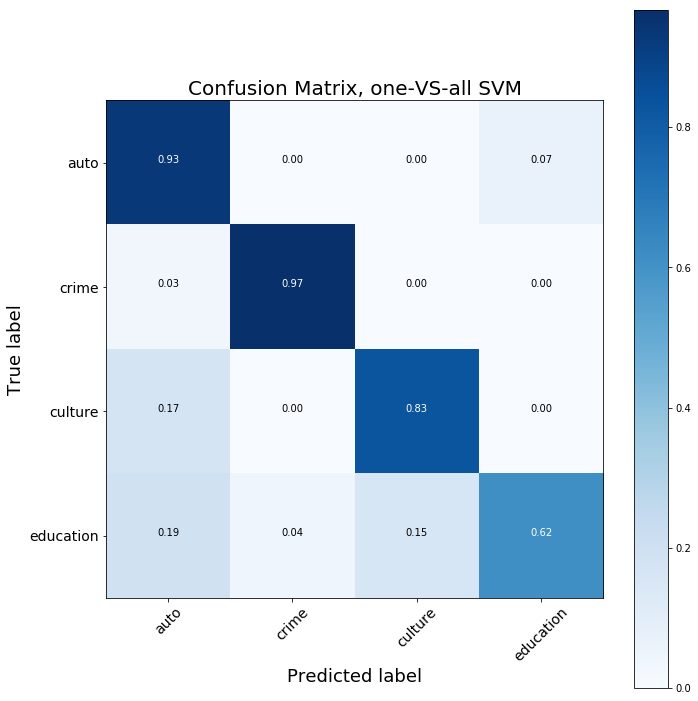

In [113]:
cmt_svm_onevsall = confusion_matrix(y_test, y_pred_onevsall)
plot_confusion_matrix(cmt_svm_onevsall, title='Confusion Matrix, one-VS-all SVM')

In [114]:
predictor_oneVSone = OneVsOneClassifier(LinearSVC(), n_jobs=8).fit(X_train, y_train)

In [115]:
y_pred_onevsone = predictor_oneVSone.predict(X_test)
print ('One-VS-one accuracy: {}'.format(round(np.mean(y_test == y_pred_onevsone), 2)))

One-VS-one accuracy: 0.83


In [116]:
y_pred_onevsone[y_pred_onevsone !=y_test]

array(['auto', 'auto', 'culture', 'culture', 'culture', 'culture', 'auto',
       'auto', 'culture', 'auto', 'auto', 'auto', 'auto', 'education',
       'education', 'auto', 'education', 'auto', 'culture', 'education'],
      dtype='<U9')

In [117]:
pd.Series(y_pred_onevsone)!=y_test

0      False
1       True
2      False
3      False
4      False
5      False
6       True
7      False
8      False
9      False
10      True
11     False
12      True
13     False
14     False
15      True
16     False
17     False
18     False
19     False
20     False
21     False
22      True
23     False
24     False
25      True
26     False
27     False
28      True
29      True
       ...  
85     False
86     False
87     False
88     False
89     False
90     False
91     False
92     False
93     False
94     False
95     False
96     False
97     False
98     False
99     False
100    False
101    False
102    False
103    False
104    False
105    False
106     True
107    False
108    False
109     True
110    False
111    False
112    False
113    False
114    False
Length: 115, dtype: bool

In [118]:
print(y_pred_onevsone[8])
print(y_test[8])

auto
auto


In [119]:
test_x.index = pd.RangeIndex(len(test_x))
test_x[8]

['вечер',
 'январ',
 'км',
 'автодорог',
 'кол',
 'произошл',
 'дтп',
 'участ',
 'пят',
 'автомобил',
 'числ',
 'грузов',
 'информац',
 'авар',
 'поступ',
 'мчс',
 'еха',
 'машин',
 'пол',
 'вынесл',
 'сугроб',
 'лев',
 'полос',
 'успел',
 'поня',
 'откуд',
 'взял',
 'приеха',
 'водительск',
 'двер',
 'машин',
 'цел',
 'подушк',
 'сработа',
 'пристегнут',
 'мерседес',
 'поня',
 'порядк',
 'пишет',
 'социальн',
 'сет',
 'вконтакт',
 'валер',
 'сообщен',
 'очевидц',
 'результат',
 'авар',
 'никт',
 'серьезн',
 'пострада',
 'обстоятельств',
 'выясня']

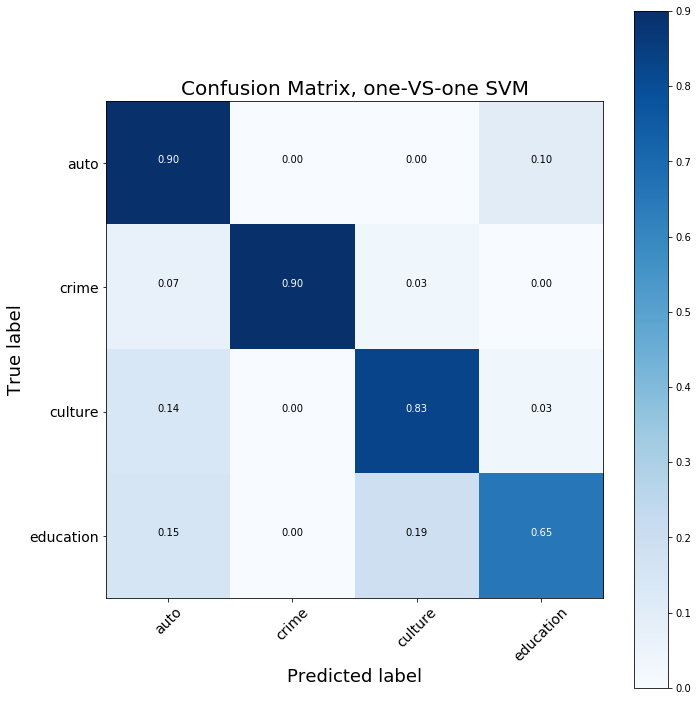

In [120]:
cmt_svm_onevsone = confusion_matrix(y_test, y_pred_onevsone)
plot_confusion_matrix(cmt_svm_onevsone, title='Confusion Matrix, one-VS-one SVM')

In [121]:
for c in np.unique(y_train):
    print ('Class \'{}\' samples N: {}'.format(c, y_train[y_train == c].shape[0]))

Class 'auto' samples N: 118
Class 'crime' samples N: 121
Class 'culture' samples N: 114
Class 'education' samples N: 103


In [122]:
X_train_bin = X_train[(y_train == 'culture') | (y_train == 'education')]
y_train_bin = y_train[(y_train == 'culture') | (y_train == 'education')]

y_train_bin[y_train_bin == 'culture'] = 0
y_train_bin[y_train_bin == 'education'] = 1
y_train_bin = y_train_bin.astype(int)

print (X_train_bin.shape, y_train_bin.shape)

(217, 30) (217,)


In [123]:
X_test_bin = X_test[(y_test == 'culture') | (y_test == 'education')]
y_test_bin = y_test[(y_test == 'culture') | (y_test == 'education')]

y_test_bin[y_test_bin == 'culture'] = 0
y_test_bin[y_test_bin == 'education'] = 1
y_test_bin = y_test_bin.astype(int)

print (X_test_bin.shape, y_test_bin.shape)

(55, 30) (55,)


In [124]:
one_binary_predictor = RandomForestClassifier(n_estimators=100).fit(X_train_bin, y_train_bin)

### [Metrics](https://en.wikipedia.org/wiki/Precision_and_recall)

In [125]:
y_pred_binary = one_binary_predictor.predict(X_test_bin)

print ('Binary classifiers accuracy: {}'.format(round(np.mean(y_pred_binary == y_test_bin), 2)))

Binary classifiers accuracy: 0.85


In [126]:
def FP(y_true, y_pred):
    return float(np.sum(y_true[y_true == 0] != y_pred[y_true == 0]))

In [127]:
def TP(y_true, y_pred):
    return float(np.sum(y_true[y_true == 1] == y_pred[y_true == 1]))

In [128]:
def FN(y_true, y_pred):
    return float(np.sum(y_true[y_true == 1] != y_pred[y_true == 1]))

In [129]:
def TN(y_true, y_pred):
    return float(np.sum(y_true[y_true == 0] == y_pred[y_true == 0]))

In [130]:
fp = FP(y_test_bin, y_pred_binary)
fn = FN(y_test_bin, y_pred_binary)
tp = TP(y_test_bin, y_pred_binary)
tn = TN(y_test_bin, y_pred_binary)

print ('TP = {}, FP = {}, TN = {}, FN = {}\n---------------------------------------------\nsum = {}'.format(tp, fp, tn, fn, tp + fp + tn + fn))

TP = 23.0, FP = 5.0, TN = 24.0, FN = 3.0
---------------------------------------------
sum = 55.0


In [131]:
P = precision_score(y_test_bin, y_pred_binary)
R = recall_score(y_test_bin, y_pred_binary)

print ('Precision: {}, Recall: {}'.format(P, R))

Precision: 0.8214285714285714, Recall: 0.8846153846153846


In [132]:
print (tp / (tp + fp), tp / (tp + fn))

0.8214285714285714 0.8846153846153846


In [133]:
print ('F1: {}'.format(f1_score(y_test_bin, y_pred_binary)))

F1: 0.8518518518518519


In [134]:
print (2.0 * P * R / (P + R))

0.8518518518518519


In [135]:
X_test_bin.shape

(55, 30)

In [136]:
scores_binary = one_binary_predictor.predict_proba(X_test_bin)[:, 1]

print (scores_binary.shape)

(55,)


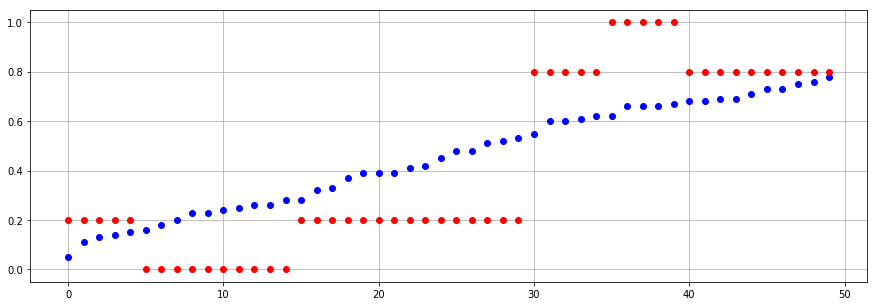

In [138]:
plt.figure(figsize=(15, 5))

N_batch = 10
inds = np.argsort(scores_binary)
scores_sorted = scores_binary[inds]
y_sorted = y_test_bin[inds]
q = len(y_test_bin) // N_batch

for i in range(N_batch):
    plt.plot(range(q * i, q * (i + 1)), scores_sorted[q * i : q * (i + 1)],'ob')
    plt.plot(range(q * i, q * (i + 1)), [np.mean(y_sorted[q * i : q * (i + 1)])] * q, 'ro')
    
plt.grid(True)

In [139]:
fpr, tpr, thresholds = roc_curve(y_test_bin, scores_binary)

(-0.1, 1.1)

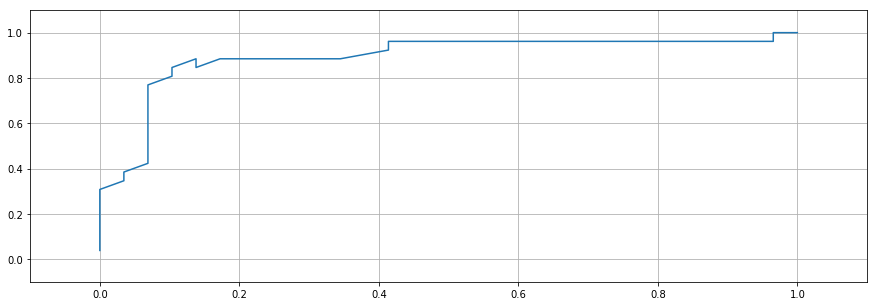

In [140]:
plt.figure(figsize=(15, 5))

inds = np.argsort(fpr)
plt.plot(fpr[inds], tpr[inds])
plt.grid(True)
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)

In [142]:
roc_auc = roc_auc_score(y_test_bin, scores_binary)

print ('AUC score: {}'.format(roc_auc, 2))

AUC score: 0.8919098143236074


In [56]:
f1_max = 0
y_pred_best = None

for thr in thresholds:
    y_pred_tuned = scores_binary.copy()
    y_pred_tuned[y_pred_tuned < thr] = 0
    y_pred_tuned[y_pred_tuned >= thr] = 1
    
    f1 = f1_score(y_test_bin, y_pred_tuned)
    if f1 > f1_max:
        f1_max = f1
        y_pred_best = y_pred_tuned
    if f1 > 0.894308943089:
        print 'thr = {}: F1 +{}'.format(thr, round(f1 - 0.8920570264765784, 4))
        
print
print 'Max. F1: {}'.format(round(f1_max, 3))

thr = 0.504785655909: F1 +0.0035
thr = 0.485095370974: F1 +0.0031
thr = 0.480729676346: F1 +0.0057
thr = 0.480516493463: F1 +0.0039
thr = 0.469977336138: F1 +0.0083
thr = 0.46990937657: F1 +0.0066
thr = 0.467158472881: F1 +0.0131
thr = 0.466458427364: F1 +0.0113
thr = 0.462352420533: F1 +0.0199
thr = 0.458340955617: F1 +0.0163
thr = 0.45658557643: F1 +0.0184
thr = 0.455257528258: F1 +0.0167
thr = 0.454569310697: F1 +0.0209
thr = 0.447121968459: F1 +0.0191
thr = 0.44270785316: F1 +0.0212
thr = 0.437210235221: F1 +0.0195
thr = 0.437015086662: F1 +0.0216
thr = 0.434122501169: F1 +0.0129
thr = 0.430693801046: F1 +0.015
thr = 0.421791120273: F1 +0.0081
thr = 0.420593583687: F1 +0.0102
thr = 0.419017649164: F1 +0.0085
thr = 0.409890690352: F1 +0.0106
thr = 0.396582332444: F1 +0.003

Max. F1: 0.914


In [57]:
print np.mean(y_test_bin == y_pred_best)

0.9307692307692308


## Ensembling

In [58]:
print np.mean(RandomForestClassifier(n_estimators=10).fit(X_train, y_train).predict(X_test) == y_test)
print np.mean(RandomForestClassifier(n_estimators=100, criterion='entropy').fit(X_train, y_train).predict(X_test) == y_test)
print np.mean(GradientBoostingClassifier(n_estimators=10).fit(X_train, y_train).predict(X_test) == y_test)

0.503755364806867
0.574928469241774
0.5160944206008584


In [59]:
ensemble_soft = VotingClassifier([('rf_gini_10', RandomForestClassifier(n_estimators=10)),
                                  ('rf_entropy_100', RandomForestClassifier(n_estimators=100, criterion='entropy')),
                                  ('gbt_100', GradientBoostingClassifier(n_estimators=10))], voting='soft', n_jobs=1)

ensemble_hard = VotingClassifier([('rf_gini_10', RandomForestClassifier(n_estimators=10)),
                                  ('rf_entropy_100', RandomForestClassifier(n_estimators=100, criterion='entropy')),
                                  ('gbt_100', GradientBoostingClassifier(n_estimators=10))], voting='hard', n_jobs=1)

In [60]:
ensemble_soft.fit(X_train, y_train)
ensemble_hard.fit(X_train, y_train)

VotingClassifier(estimators=[('rf_gini_10', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
          ...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [61]:
y_pred_hard = ensemble_hard.predict(X_test)
y_pred_soft = ensemble_soft.predict(X_test)

print y_pred_hard.shape, y_pred_soft.shape

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(5592,) (5592,)


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [62]:
print 'Hard voting accuracy: {}%'.format(round(np.mean(y_test == y_pred_hard), 2))
print 'Soft voting accuracy: {}%'.format(round(np.mean(y_test == y_pred_soft), 2))

Hard voting accuracy: 0.57%
Soft voting accuracy: 0.58%
